<a href="https://colab.research.google.com/github/fatemafaria142/Natural-Language-Understanding-in-English-with-MultiNLI-Corpus/blob/main/Natural_Language_Inference_using_RoBERTa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
from tqdm import tqdm
import time
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,log_loss,jaccard_score,roc_auc_score,classification_report,confusion_matrix
from torch.utils.data import Dataset, DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.6 MB/s eta 0:00:00


### **Dataset link:** https://huggingface.co/datasets/multi_nli

In [5]:
from datasets import load_dataset

dataset = load_dataset("multi_nli")

In [6]:
# Access train, test, and validation splits
train_data = dataset['train']
# Optional: You can also print the number of examples in each split
print(f"Number of examples in train set: {len(train_data)}")

Number of examples in train set: 392702


# **Train Dataset**

In [7]:
# Access train data
train_data = dataset['train']

# Create a DataFrame from the dataset
df_train = pd.DataFrame(train_data[:15000])  # Taking the first 15,000 rows

# Map numeric labels to textual representations
label_map = {
    2: 'Contradiction',
    0: 'Entailment',
    1: 'Neutral'
}

df_train['label'] = df_train['label'].map(label_map)

# Keep only 'premise', 'hypothesis', and 'label' columns
df_train = df_train[['premise', 'hypothesis', 'label']]

# Display the modified DataFrame with the selected columns
df_train.head()


,premise,hypothesis,label
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,Neutral
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,Entailment
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,Entailment
3,How do you know? All this is their information...,This information belongs to them.,Entailment
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,Neutral


# **Test Dataset**

In [8]:
# Access train data
test_data = dataset['train']

# Create a DataFrame from the dataset
df_test = pd.DataFrame(train_data[15000:16000])  # Taking the first 15,000 rows

# Map numeric labels to textual representations
label_map = {
    2: 'Contradiction',
    0: 'Entailment',
    1: 'Neutral'
}

df_test['label'] = df_test['label'].map(label_map)

# Keep only 'premise', 'hypothesis', and 'label' columns
df_test = df_test[['premise', 'hypothesis', 'label']]

# Display the modified DataFrame with the selected columns
df_test.head()

,premise,hypothesis,label
0,"6. Boys Don't Cry . Starkly beautiful, Kimberl...",Boys Don't Cry is Kimberly Peirce's debut film.,Entailment
1,"Sergeant, just what is going on here?""Whoever,...",Drew could never forget the sound of a turkey ...,Entailment
2,Unlike past laws restricting the work of legal...,Legal services have always been available to e...,Contradiction
3,oh yeah i mean the the stud fee is worse i mea...,Stud fees are a few hundred.,Entailment
4,And anecdotes usually don't show the reasons f...,The anecdotes are not always helpful for solut...,Entailment


# **Validation Dataset**

In [9]:
# Access train data
validation_data = dataset['train']

# Create a DataFrame from the dataset
df_validation = pd.DataFrame(train_data[16000:17000])  # Taking the first 15,000 rows

# Map numeric labels to textual representations
label_map = {
    2: 'Contradiction',
    0: 'Entailment',
    1: 'Neutral'
}

df_validation['label'] = df_validation['label'].map(label_map)

# Keep only 'premise', 'hypothesis', and 'label' columns
df_validation = df_validation[['premise', 'hypothesis', 'label']]

# Display the modified DataFrame with the selected columns
df_validation.head()

,premise,hypothesis,label
0,"Surprisingly, the $10 million spectacular isn'...",The color purple was expected to flop at it's ...,Neutral
1,and anyway uh where uh oh we're talking about ...,The company has grown very big since I got here.,Neutral
2,"To provide a basis for pay, leave, and benefit...",There is no record of hours worked.,Contradiction
3,DOD has recognized the nature of this problem ...,The DOD is now advocating using best practices.,Entailment
4,"For business, Hong Kong is still a good place ...",China has an increasing amount of money.,Neutral


# **Visualization of Label Distribution in Train dataset**
* 0: 'Entailment'
* 1: 'Neutral'   
* 2: 'Contradiction'


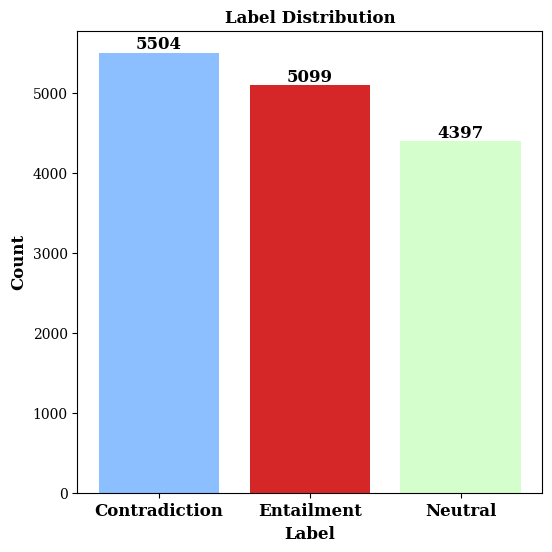

In [10]:
label_counts = df_train['label'].value_counts()

# Define custom colors for the bars ('e', 'c', and 'n')
custom_colors = ['#8cbfff', '#d62728','#d4ffcc']

# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

plt.figure(figsize=(6, 6))

# Create bar plot with grid
bars = plt.bar(label_counts.index, label_counts.values, color=custom_colors)
#plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set title and axis labels using custom fontdict
plt.title('Label Distribution', fontdict=font)
plt.xlabel('Label', fontdict=font)
plt.ylabel('Count', fontdict=font)

# Set custom font for ticks on both x and y axes
plt.xticks(label_counts.index, label_counts.index, fontdict=font)
plt.yticks(fontname='Serif', fontsize=10)

# Adding annotations (count values) on top of each bar
for bar, count in zip(bars, label_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontdict=font)

# Show the plot
plt.show()


# **Visualization of Label Distribution in Test dataset**
* 0: 'Entailment'
* 1: 'Neutral'   
* 2: 'Contradiction'


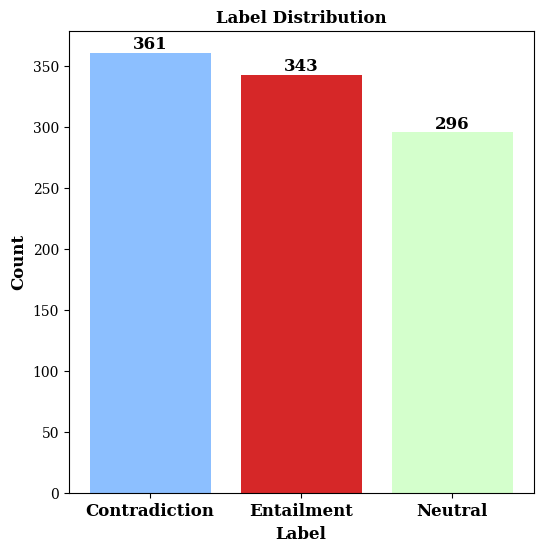

In [11]:
label_counts = df_test['label'].value_counts()

# Define custom colors for the bars ('e', 'c', and 'n')
custom_colors = ['#8cbfff', '#d62728','#d4ffcc']

# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

plt.figure(figsize=(6, 6))

# Create bar plot with grid
bars = plt.bar(label_counts.index, label_counts.values, color=custom_colors)
#plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set title and axis labels using custom fontdict
plt.title('Label Distribution', fontdict=font)
plt.xlabel('Label', fontdict=font)
plt.ylabel('Count', fontdict=font)

# Set custom font for ticks on both x and y axes
plt.xticks(label_counts.index, label_counts.index, fontdict=font)
plt.yticks(fontname='Serif', fontsize=10)

# Adding annotations (count values) on top of each bar
for bar, count in zip(bars, label_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontdict=font)

# Show the plot
plt.show()


# **Visualization of Label Distribution in Validation dataset**
* 0: 'Entailment'
* 1: 'Neutral'   
* 2: 'Contradiction'


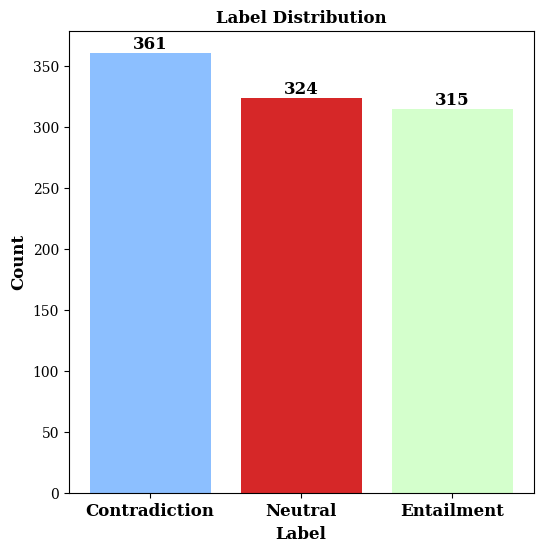

In [12]:
label_counts = df_validation['label'].value_counts()

# Define custom colors for the bars ('e', 'c', and 'n')
custom_colors = ['#8cbfff', '#d62728','#d4ffcc']

# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

plt.figure(figsize=(6, 6))

# Create bar plot with grid
bars = plt.bar(label_counts.index, label_counts.values, color=custom_colors)
#plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set title and axis labels using custom fontdict
plt.title('Label Distribution', fontdict=font)
plt.xlabel('Label', fontdict=font)
plt.ylabel('Count', fontdict=font)

# Set custom font for ticks on both x and y axes
plt.xticks(label_counts.index, label_counts.index, fontdict=font)
plt.yticks(fontname='Serif', fontsize=10)

# Adding annotations (count values) on top of each bar
for bar, count in zip(bars, label_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontdict=font)

# Show the plot
plt.show()


# **Visualization of Premise Length Distribution in Train Dataset**


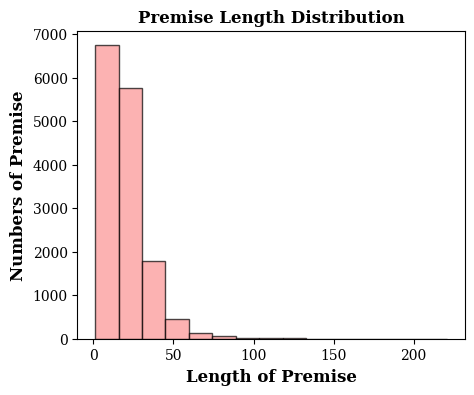

In [13]:
# Visualize premise length distribution
premise_lengths = df_train['premise'].apply(lambda x: len(x.split()))
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}
custom_colors = ['#fc9292']
plt.figure(figsize=(5, 4))
plt.hist(premise_lengths, bins=15, color=custom_colors,edgecolor='black' ,alpha=0.7)

# Set title and axis labels using custom fontdict
plt.title('Premise Length Distribution',fontdict=font)
plt.xlabel('Length of Premise',fontdict=font)
plt.ylabel('Numbers of Premise',fontdict=font)

# Set custom font for ticks on both x and y axes
plt.xticks(fontname='Serif', fontsize=10)
plt.yticks(fontname='Serif', fontsize=10)
#plt.grid(True)
plt.show()

# **Visualization of Premise Length Distribution in Test Dataset**


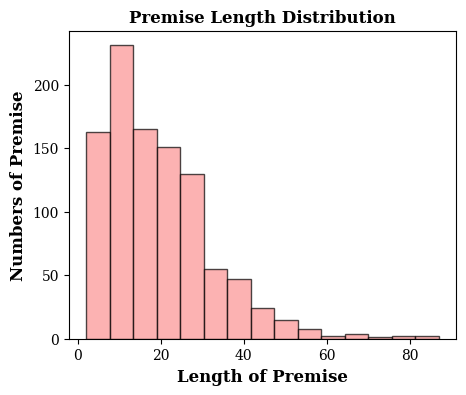

In [14]:
# Visualize premise length distribution
premise_lengths = df_test['premise'].apply(lambda x: len(x.split()))
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}
custom_colors = ['#fc9292']
plt.figure(figsize=(5, 4))
plt.hist(premise_lengths, bins=15, color=custom_colors,edgecolor='black' ,alpha=0.7)

# Set title and axis labels using custom fontdict
plt.title('Premise Length Distribution',fontdict=font)
plt.xlabel('Length of Premise',fontdict=font)
plt.ylabel('Numbers of Premise',fontdict=font)

# Set custom font for ticks on both x and y axes
plt.xticks(fontname='Serif', fontsize=10)
plt.yticks(fontname='Serif', fontsize=10)
#plt.grid(True)
plt.show()

# **Visualization of Premise Length Distribution in Validation Dataset**


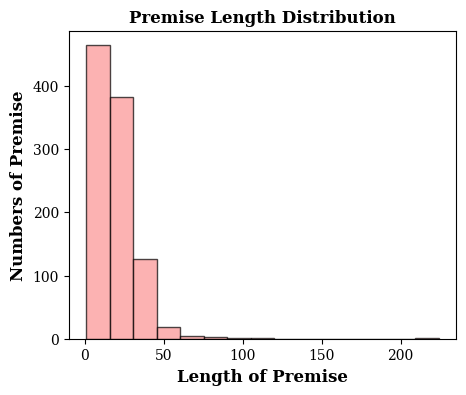

In [15]:
# Visualize premise length distribution
premise_lengths = df_validation['premise'].apply(lambda x: len(x.split()))
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}
custom_colors = ['#fc9292']
plt.figure(figsize=(5, 4))
plt.hist(premise_lengths, bins=15, color=custom_colors,edgecolor='black' ,alpha=0.7)

# Set title and axis labels using custom fontdict
plt.title('Premise Length Distribution',fontdict=font)
plt.xlabel('Length of Premise',fontdict=font)
plt.ylabel('Numbers of Premise',fontdict=font)

# Set custom font for ticks on both x and y axes
plt.xticks(fontname='Serif', fontsize=10)
plt.yticks(fontname='Serif', fontsize=10)
#plt.grid(True)
plt.show()

# **Dataset Length**

In [16]:
print(f"Train Dataset Length: {len(df_train)}")
print(f"Test Dataset Length: {len(df_test)}")
print(f"Validation Dataset Length: {len(df_validation)}")

Train Dataset Length: 15000
Test Dataset Length: 1000
Validation Dataset Length: 1000


# **Null value checking in Train dataset**

In [17]:
# Check for null values in 'premise', 'hypothesis' and	'label' columns
null_premise = df_train['premise'].isnull().sum()
null_hypothesis = df_train['hypothesis'].isnull().sum()
null_label = df_train['label'].isnull().sum()


print(f"Null values in 'premise': {null_premise}")
print(f"Null values in 'hypothesis': {null_hypothesis}")
print(f"Null values in 'label': {null_label}")


Null values in 'premise': 0
Null values in 'hypothesis': 0
Null values in 'label': 0


# **Null value checking in Test dataset**

In [18]:
# Check for null values in 'premise', 'hypothesis' and	'label' columns
null_premise = df_test['premise'].isnull().sum()
null_hypothesis = df_test['hypothesis'].isnull().sum()
null_label = df_test['label'].isnull().sum()


print(f"Null values in 'premise': {null_premise}")
print(f"Null values in 'hypothesis': {null_hypothesis}")
print(f"Null values in 'label': {null_label}")


Null values in 'premise': 0
Null values in 'hypothesis': 0
Null values in 'label': 0


# **Null value checking in Validation dataset**

In [19]:
# Check for null values in 'premise', 'hypothesis' and	'label' columns
null_premise = df_validation['premise'].isnull().sum()
null_hypothesis = df_validation['hypothesis'].isnull().sum()
null_label = df_validation['label'].isnull().sum()


print(f"Null values in 'premise': {null_premise}")
print(f"Null values in 'hypothesis': {null_hypothesis}")
print(f"Null values in 'label': {null_label}")


Null values in 'premise': 0
Null values in 'hypothesis': 0
Null values in 'label': 0


# **Roberta model and its tokenizer**

In [22]:
from transformers import AutoTokenizer, RobertaForSequenceClassification , AdamW
num_classes = 3  #number of classes in our dataset
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")
model = RobertaForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-emotion", problem_type="multi_label_classification",num_labels=num_classes,ignore_mismatched_sizes=True)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# Place model on the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [24]:
from torch.utils.data import Dataset, DataLoader
import torch

# **Custom Dataset Class**

In [25]:
class NaturalLanguageInferenceDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=256):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label_map = {'Contradiction': 2, 'Entailment': 0, 'Neutral': 1}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        premise = self.data.iloc[idx]['premise']
        hypothesis = self.data.iloc[idx]['hypothesis']
        label = self.data.iloc[idx]['label']

        # Map label to integer
        label_id = self.label_map[label]

        # Tokenize premise and hypothesis separately
        encoded_dict_premise = self.tokenizer.encode_plus(
            premise,
            add_special_tokens=True,
            max_length=self.max_length // 2,  # Allocate half of the max_length to each
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        encoded_dict_hypothesis = self.tokenizer.encode_plus(
            hypothesis,
            add_special_tokens=True,
            max_length=self.max_length // 2,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        # Concatenate input_ids and attention_masks
        input_ids = torch.cat((encoded_dict_premise['input_ids'], encoded_dict_hypothesis['input_ids']), dim=1)
        attention_mask = torch.cat((encoded_dict_premise['attention_mask'], encoded_dict_hypothesis['attention_mask']), dim=1)

        return {
            'input_ids': input_ids.squeeze(),
            'attention_mask': attention_mask.squeeze(),
            'label': torch.tensor(label_id, dtype=torch.long)  # Use mapped label_id
        }


# **Custom dataset and dataloader**

In [26]:
# Define custom datasets
train_dataset = NaturalLanguageInferenceDataset(df_train, tokenizer)
val_dataset = NaturalLanguageInferenceDataset(df_validation, tokenizer)
test_dataset = NaturalLanguageInferenceDataset(df_test, tokenizer)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

# **Train Dataset Encoding Printing**

In [27]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in train_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}  # Using 'batch' directly

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]


    # Print information
    print("Input IDs:", input_ids)
    print("Attention Mask:", attention_mask)
    print("Labels:", labels)


    # Break out of the loop after processing the first batch
    break


Input IDs: tensor([    0, 15638, 32392,    23,   123, 44324,  1657,     4,     2,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,    

# **Test Dataset Encoding Printing**

In [28]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in test_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}  # Using 'batch' directly

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]


    # Print information
    print("Input IDs:", input_ids)
    print("Attention Mask:", attention_mask)
    print("Labels:", labels)


    # Break out of the loop after processing the first batch
    break


Input IDs: tensor([    0,   401,     4,  8732,  1599,    75, 19803,   479, 19772,   352,
         2721,     6, 19278,  4119,   853,  1755,    18,  2453,   822,    34,
           23,    63,  2731,    10,  8805, 30344,  1437,   280,     5,  2116,
           12,   417,  9828,  5805,  2941,  4242,     6,    10,   449,    10,
         2941,  4242,  5805,    36,   627, 34524, 39384,  5141,  3323,  3153,
           43,  2653,   144,    23,   184,   566,     5,  2345,     9,  6744,
          858, 15291,    54,    74,  3549,    69,   114,    51,  1467,    69,
         1528,  3959,     4,     2,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,    

# **Validation Dataset Encoding Printing**

In [29]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in val_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}  # Using 'batch' directly

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]


    # Print information
    print("Input IDs:", input_ids)
    print("Attention Mask:", attention_mask)
    print("Labels:", labels)


    # Break out of the loop after processing the first batch
    break


Input IDs: tensor([    0, 27526, 47607,     6,     5,    68,   698,   153,  8694,   965,
           75,  7099,    18,    70,    12,   958,   934,  2342,  1517,     4,
            2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,    

# **Train Dataset Decoding Printing**

In [34]:
# Set a flag to track whether it's the first batch
first_batch = True

# Iterate through the DataLoader
for batch in train_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]

    # Check for problematic token IDs causing overflow error during decoding
    problematic_ids = torch.nonzero((input_ids < 0) | (input_ids >= tokenizer.vocab_size))
    if problematic_ids.numel() > 0:
        print("Problematic Token IDs:", input_ids[problematic_ids])
        print("Problematic Token Positions:", problematic_ids)
        # Handle the problematic input IDs as needed
        raise ValueError("Problematic token IDs detected")

    # Decode and print input text
    decoded_input_text = tokenizer.decode(input_ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Decoded Input Text:", decoded_input_text)
    print("Attention Mask:", attention_mask)

    # Decode and print labels
    decoded_labels = labels.item()  # Assuming labels are single integers
    print("Label:", decoded_labels)

    # Break out of the loop after processing the first sample from the first batch
    break

Decoded Input Text:  the uncompromising Vel?¡zquez portrait of ugly Queen Marianna of Austria; El Greco's powerfully mystic Christ on the Crose Ribera's gruesomely good-humored The Club Foot.El Greco was a extremely famous Spanish painter whose work was often religious.
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# **Test Dataset Decoding Printing**

In [35]:
# Set a flag to track whether it's the first batch
first_batch = True

# Iterate through the DataLoader
for batch in test_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]

    # Check for problematic token IDs causing overflow error during decoding
    problematic_ids = torch.nonzero((input_ids < 0) | (input_ids >= tokenizer.vocab_size))
    if problematic_ids.numel() > 0:
        print("Problematic Token IDs:", input_ids[problematic_ids])
        print("Problematic Token Positions:", problematic_ids)
        # Handle the problematic input IDs as needed
        raise ValueError("Problematic token IDs detected")

    # Decode and print input text
    decoded_input_text = tokenizer.decode(input_ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Decoded Input Text:", decoded_input_text)
    print("Attention Mask:", attention_mask)

    # Decode and print labels
    decoded_labels = labels.item()  # Assuming labels are single integers
    print("Label:", decoded_labels)

    # Break out of the loop after processing the first sample from the first batch
    break

Decoded Input Text: 6. Boys Don't Cry. Starkly beautiful, Kimberly Peirce's debut film has at its core a tragicomic  That the cross-dressing Brandon Teena, a k a Teena Brandon (the rapturous Hillary Swank) feels most at home among the sort of roughnecks who would kill her if they knew her true gender.Boys Don't Cry is Kimberly Peirce's debut film.
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

# **Validation Dataset Decoding Printing**

In [36]:
# Set a flag to track whether it's the first batch
first_batch = True

# Iterate through the DataLoader
for batch in val_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]

    # Check for problematic token IDs causing overflow error during decoding
    problematic_ids = torch.nonzero((input_ids < 0) | (input_ids >= tokenizer.vocab_size))
    if problematic_ids.numel() > 0:
        print("Problematic Token IDs:", input_ids[problematic_ids])
        print("Problematic Token Positions:", problematic_ids)
        # Handle the problematic input IDs as needed
        raise ValueError("Problematic token IDs detected")

    # Decode and print input text
    decoded_input_text = tokenizer.decode(input_ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Decoded Input Text:", decoded_input_text)
    print("Attention Mask:", attention_mask)

    # Decode and print labels
    decoded_labels = labels.item()  # Assuming labels are single integers
    print("Label:", decoded_labels)

    # Break out of the loop after processing the first sample from the first batch
    break


Decoded Input Text: Surprisingly, the $10 million spectacular isn't Broadway's all-time biggest flop.The color purple was expected to flop at it's first premiere. 
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 

# **Optimizer and Loss Function**

In [37]:
# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

# **Training the model**

In [38]:
# Training loop
num_epochs = 15
gradient_accumulation_steps = 4  # Accumulate gradients over 4 steps

for epoch in range(num_epochs):
    start_time = time.time()  # Start time of the epoch
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    # Wrap train_loader with tqdm for progress bar
    for batch_idx, batch in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Logits directly from the model output

        loss = criterion(logits, labels)
        total_loss += loss.item()

        loss = loss / gradient_accumulation_steps
        loss.backward()

        if (batch_idx + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    avg_train_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{num_epochs} - Average training loss: {avg_train_loss:.4f}')

    # Validation
    model.eval()
    val_preds = []
    val_labels = []

    # Wrap val_loader with tqdm for progress bar
    for batch in tqdm(val_loader, desc=f'Validation', leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Logits directly from the model output

        _, predicted = torch.max(logits, 1)

        val_preds.extend(predicted.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(val_labels, val_preds)
    print(f'Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {val_accuracy:.4f}')

    # Calculate and print epoch training time
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch + 1} completed in {epoch_time // 60:.0f}m {epoch_time % 60:.0f}s")

Epoch 1/15 - Average training loss: 0.7391


Epoch 1/15 - Validation Accuracy: 0.7860
Epoch 1 completed in 10m 16s


Epoch 2/15 - Average training loss: 0.4477


Epoch 2/15 - Validation Accuracy: 0.7970
Epoch 2 completed in 10m 19s


Epoch 3/15 - Average training loss: 0.2845


Epoch 3/15 - Validation Accuracy: 0.7840
Epoch 3 completed in 10m 19s


Epoch 4/15 - Average training loss: 0.1769


Epoch 4/15 - Validation Accuracy: 0.7740
Epoch 4 completed in 10m 20s


Epoch 5/15 - Average training loss: 0.1200


Epoch 5/15 - Validation Accuracy: 0.7740
Epoch 5 completed in 10m 19s


Epoch 6/15 - Average training loss: 0.0817


Epoch 6/15 - Validation Accuracy: 0.8040
Epoch 6 completed in 10m 19s


Epoch 7/15 - Average training loss: 0.0600


Epoch 7/15 - Validation Accuracy: 0.7950
Epoch 7 completed in 10m 18s


Epoch 8/15 - Average training loss: 0.0567


Epoch 8/15 - Validation Accuracy: 0.7910
Epoch 8 completed in 10m 18s


Epoch 9/15 - Average training loss: 0.0414


Epoch 9/15 - Validation Accuracy: 0.7890
Epoch 9 completed in 10m 18s


Epoch 10/15 - Average training loss: 0.0363


Epoch 10/15 - Validation Accuracy: 0.7880
Epoch 10 completed in 10m 19s


Epoch 11/15 - Average training loss: 0.0332


Epoch 11/15 - Validation Accuracy: 0.7630
Epoch 11 completed in 10m 18s


Epoch 12/15 - Average training loss: 0.0324


Epoch 12/15 - Validation Accuracy: 0.7910
Epoch 12 completed in 10m 18s


Epoch 13/15 - Average training loss: 0.0237


Epoch 13/15 - Validation Accuracy: 0.7860
Epoch 13 completed in 10m 18s


Epoch 14/15 - Average training loss: 0.0239


Epoch 14/15 - Validation Accuracy: 0.7790
Epoch 14 completed in 10m 19s


Epoch 15/15 - Average training loss: 0.0250


Epoch 15/15 - Validation Accuracy: 0.7780
Epoch 15 completed in 10m 19s


# **Testing the model**

In [39]:
test_preds = []
test_labels = []
test_probs = []  # Store predicted probabilities

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Testing'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Assuming our model directly outputs logits
        probabilities = torch.softmax(outputs.logits, dim=1)  # Softmax to get probabilities
        _, predicted = torch.max(outputs.logits, 1)

        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(probabilities.cpu().numpy())  # Append predicted probabilities

test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average='macro')
test_recall = recall_score(test_labels, test_preds, average='macro')
test_f1 = f1_score(test_labels, test_preds, average='macro')
test_jaccard_score = jaccard_score(test_labels, test_preds, average='macro')
test_log_loss = log_loss(test_labels, test_probs)


Testing: 100%|██████████| 100/100 [00:13<00:00,  7.44it/s]


In [40]:
print(test_preds)
print(test_labels)

[0, 2, 2, 2, 1, 2, 1, 0, 2, 2, 2, 1, 0, 2, 1, 2, 2, 1, 2, 0, 2, 2, 0, 1, 0, 1, 2, 2, 0, 0, 0, 0, 2, 2, 0, 1, 0, 1, 0, 2, 2, 2, 2, 2, 1, 1, 0, 0, 1, 2, 1, 2, 2, 0, 2, 1, 1, 2, 0, 0, 1, 1, 1, 2, 0, 2, 0, 2, 2, 1, 2, 1, 2, 2, 1, 0, 1, 2, 2, 2, 2, 1, 1, 2, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 1, 2, 1, 0, 2, 1, 1, 2, 0, 1, 0, 2, 1, 0, 2, 1, 2, 1, 2, 2, 2, 1, 0, 0, 1, 2, 0, 1, 2, 1, 1, 0, 1, 2, 1, 0, 2, 2, 1, 0, 2, 1, 0, 0, 2, 0, 2, 2, 0, 0, 1, 2, 2, 0, 0, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 0, 1, 1, 0, 1, 0, 2, 1, 2, 0, 2, 1, 0, 0, 1, 2, 0, 0, 2, 2, 0, 2, 1, 0, 1, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1, 0, 0, 1, 0, 2, 1, 2, 2, 0, 0, 0, 2, 1, 2, 1, 2, 0, 0, 1, 2, 0, 0, 2, 1, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 2, 0, 2, 1, 2, 0, 1, 1, 2, 2, 0, 2, 2, 0, 1, 2, 1, 2, 0, 1, 1, 1, 1, 0, 1, 2, 2, 0, 2, 1, 2, 0, 2, 1, 0, 2, 1, 2, 2, 2, 0, 2, 1, 2, 2, 1, 1, 1, 0, 1, 2, 1, 2, 2, 0, 2, 1, 2, 2, 1, 2, 1, 1, 0, 2, 2, 0, 2, 0, 0, 2, 2, 1, 2, 0, 0, 0, 1, 0, 2, 2, 1, 0, 0, 2, 0, 0, 1, 2, 1, 

# **Evaluation Metrics**

In [41]:
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')
print(f'Test F1 Score: {test_f1}')
print(f'Test Jaccard Score: {test_jaccard_score}')
print(f'Test Log Loss: {test_log_loss}')

Test Accuracy: 0.796
Test Precision: 0.7939812351327383
Test Recall: 0.7915940368382565
Test F1 Score: 0.7914472552056444
Test Jaccard Score: 0.6575197889182057
Test Log Loss: 1.1744148488746255


* For a multiclass problem, sensitivity and specificity are typically calculated using a one-vs-all (or one-vs-rest) approach. This means treating each class as the positive class once while aggregating the others as the negative class.

In [42]:
from sklearn.metrics import confusion_matrix

def sensitivity_score_multiclass(y_true, y_pred, class_label):
    cm = confusion_matrix(y_true, y_pred)
    true_positives = cm[class_label, class_label]
    actual_positives = sum(cm[class_label, :])
    return true_positives / actual_positives if actual_positives != 0 else 0

num_classes = 3  # We have 3 classes (adjust according to your dataset)

sensitivity_scores = []
for class_label in range(num_classes):
    sensitivity = sensitivity_score_multiclass(test_labels, test_preds, class_label)
    sensitivity_scores.append(sensitivity)

print("Sensitivity (Recall) for each class:", sensitivity_scores)

Sensitivity (Recall) for each class: [0.7580174927113703, 0.7331081081081081, 0.8836565096952909]


In [43]:
def specificity_score_multiclass(y_true, y_pred, class_label):
    cm = confusion_matrix(y_true, y_pred)
    true_negatives = sum(sum(cm)) - sum(cm[class_label, :]) - sum(cm[:, class_label]) + cm[class_label, class_label]
    actual_negatives = sum(sum(cm)) - sum(cm[class_label, :])
    return true_negatives / actual_negatives if actual_negatives != 0 else 0
specificity_scores = []
for class_label in range(num_classes):
    specificity = specificity_score_multiclass(test_labels, test_preds, class_label)
    specificity_scores.append(specificity)

print("Specificity for each class:", specificity_scores)


Specificity for each class: [0.928462709284627, 0.8821022727272727, 0.8841940532081377]


In [44]:
from sklearn.preprocessing import LabelBinarizer
# Convert labels to one-hot encoded format
label_binarizer = LabelBinarizer()
test_labels_one_hot = label_binarizer.fit_transform(test_labels)

# Reshape the one-hot encoded labels
num_classes = len(label_binarizer.classes_)
test_labels_one_hot = test_labels_one_hot.reshape(-1, num_classes)

# Creating a 2D array for test_preds
num_samples = len(test_preds)
num_classes = len(label_binarizer.classes_)
formatted_preds = [[0] * num_classes for _ in range(num_samples)]
for i, pred in enumerate(test_preds):
    formatted_preds[i][pred] = 1

# Calculate ROC AUC score for multiclass classification
test_roc_auc_score = roc_auc_score(test_labels_one_hot, formatted_preds, average='macro', multi_class='ovo')
print("Test ROC AUC Score:", test_roc_auc_score)

Test ROC AUC Score: 0.8449235242891344


In [45]:
# Mapping numeric labels to category names
label_map = {0: 'Entailment', 2: 'Contradiction', 1: 'Neutral'}

# Convert numeric predictions to label names
predicted_labels = [label_map[pred] for pred in test_preds]
true_labels = [label_map[label] for label in test_labels]

# Generate and print the classification report
report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(report)

Classification Report:
               precision    recall  f1-score   support

Contradiction       0.81      0.88      0.85       361
   Entailment       0.85      0.76      0.80       343
      Neutral       0.72      0.73      0.73       296

     accuracy                           0.80      1000
    macro avg       0.79      0.79      0.79      1000
 weighted avg       0.80      0.80      0.80      1000



# **Confusion Matrix for MultiNLI Dataset**

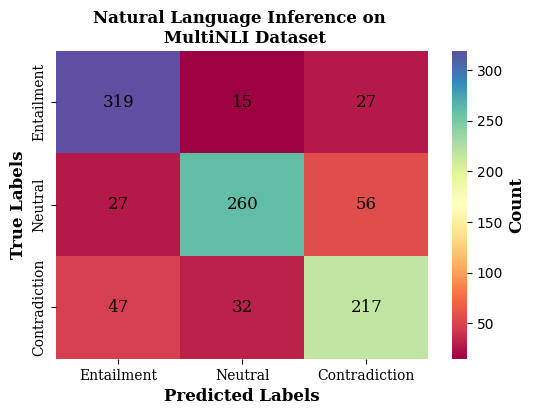

In [46]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
# Define the custom palette
custom_palette = sns.color_palette("Spectral", as_cmap=True) # Modify the number based on number of classes in the dataset
#sns.color_palette("Spectral", as_cmap=True)

# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

# Create heatmap with annotations and colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_palette,
                      xticklabels=['Entailment', 'Neutral', 'Contradiction'], yticklabels=['Entailment', 'Neutral', 'Contradiction'],annot_kws={"family": "Serif", 'size': 12, 'color':'black'})

# Set x and y labels with the custom font dictionary
heatmap.set_xlabel('Predicted Labels', fontdict=font)
heatmap.set_ylabel('True Labels', fontdict=font)
heatmap.set_title('Natural Language Inference on \n MultiNLI Dataset', fontdict=font)

# Set font properties for tick labels on both axes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontname='Serif', fontsize=10)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontname='Serif', fontsize=10)

# Create a color bar to indicate the scale
cbar = heatmap.collections[0].colorbar
cbar.set_label('Count', fontdict=font)
cbar.ax.tick_params(labelsize=10)

plt.show()


# **Save results to a csv file**

In [47]:
# Combine the lists into a DataFrame
data = {'Premise': df_test['premise'],
        'Hypothesis': df_test['hypothesis'],
        'True_Labels': df_test['label'],
        'Predicted_Labels': test_preds}
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('predicted_results.csv', index=False)


# **Save the model and its tokenizer**

In [48]:
# Save the model
model.save_pretrained('/content/drive/MyDrive/Natural_Language_Inference/NLI_roberta/NLI_roberta_Model.pt')

# Save the tokenizer
tokenizer.save_pretrained('/content/drive/MyDrive/Natural_Language_Inference/NLI_roberta/NLI_roberta_Tokenizer.json')

('/content/drive/MyDrive/Natural_Language_Inference/NLI_roberta/NLI_roberta_Tokenizer.json/tokenizer_config.json',
 '/content/drive/MyDrive/Natural_Language_Inference/NLI_roberta/NLI_roberta_Tokenizer.json/special_tokens_map.json',
 '/content/drive/MyDrive/Natural_Language_Inference/NLI_roberta/NLI_roberta_Tokenizer.json/vocab.json',
 '/content/drive/MyDrive/Natural_Language_Inference/NLI_roberta/NLI_roberta_Tokenizer.json/merges.txt',
 '/content/drive/MyDrive/Natural_Language_Inference/NLI_roberta/NLI_roberta_Tokenizer.json/added_tokens.json',
 '/content/drive/MyDrive/Natural_Language_Inference/NLI_roberta/NLI_roberta_Tokenizer.json/tokenizer.json')

# **Load the model and its tokenizer**

In [49]:
# load the model
model.from_pretrained('/content/drive/MyDrive/Natural_Language_Inference/NLI_roberta/NLI_roberta_Model.pt')

# load the tokenizer
tokenizer.from_pretrained('/content/drive/MyDrive/Natural_Language_Inference/NLI_roberta/NLI_roberta_Tokenizer.json')


RobertaTokenizerFast(name_or_path='/content/drive/MyDrive/Natural_Language_Inference/NLI_roberta/NLI_roberta_Tokenizer.json', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}